In [1]:
#For Calculations
import math
import numpy as np
import numpy.linalg as la
import numpy.ma as ma
import scipy as scp
from scipy import optimize
from cmath import sqrt
import random
from scipy.linalg import expm
import scipy.integrate as integrate
from scipy import signal
from scipy.special import erf

from numpy.random import default_rng
rng = default_rng()


#For parallel computing
from joblib import Parallel, delayed
import Encoding_Certainty_Functions as fun

In [2]:
#For Plotting results and Figures
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as tick

#Progress Bars
from tqdm.notebook import tqdm

#Setting Defaults For Plotting
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title
#Setting Linewidths
plt.rc('lines', linewidth=5.0)
#Graphic resolution
plt.rcParams['figure.dpi'] = 200

# Stationary Solutions and Stability

Here we will define the synaptic weight kernels, demonstrate how one may choose threshold values, and show some figure examples.

In [3]:
#Defining spatial discretization
n=2**12+1
dx=2*np.pi/n
x=np.linspace(-np.pi,np.pi,n)[:-1]

#For ease of interpretation x-axes are plotted in degrees
#Calculations use the radian form of x above
x_deg=np.copy(x)*180/np.pi

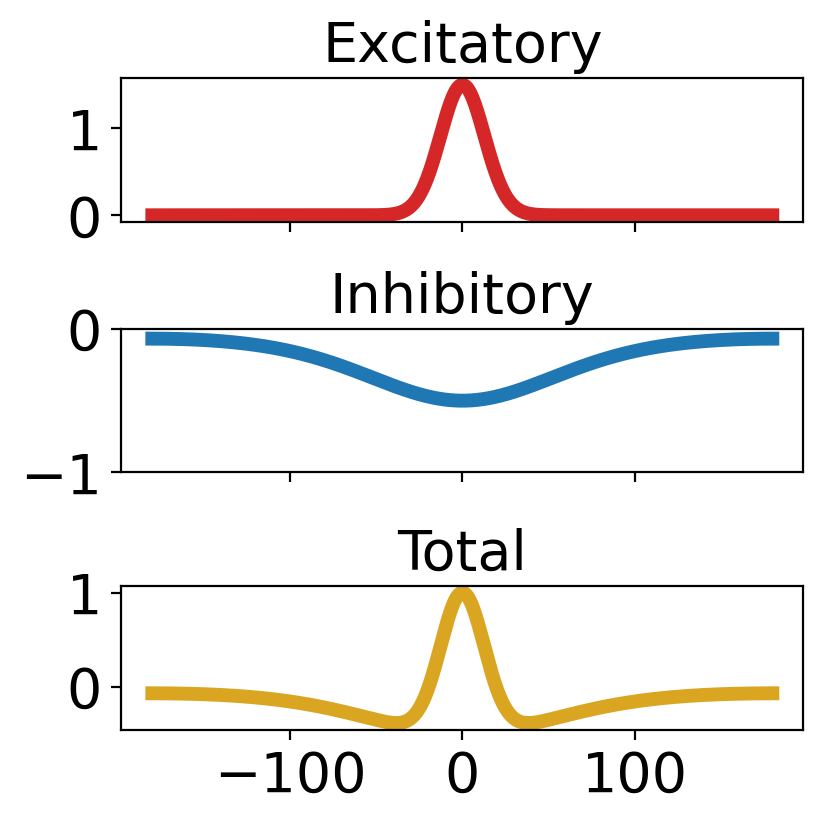

In [4]:
#Choosing weight kernels
weights_e=fun.weight_ker(1.5, 20, 20, x)
weights_i=fun.weight_ker(0.5, 1, 20, x)
weight_tot=weights_e-weights_i

#Obtaining weight kernel coefficients needed for subsequent calculations
w_coeffs=fun.weight_coeff(1.5, 20, 20)-fun.weight_coeff(0.5, 1, 20)

#Plotting weight kernels
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(4, 4), sharex=True, constrained_layout = True)
ax1.plot(x_deg,weights_e, color='tab:red')
ax1.set_title('Excitatory')

ax2.plot(x_deg,-weights_i, color='tab:blue')
ax2.set_ylim(-1,0)
ax2.set_title('Inhibitory')

ax3.plot(x_deg,weight_tot, color='goldenrod')
ax3.set_title('Total')
plt.show()

### Choosing Thresholds (N=5 example)
We now seek to find thresholds that will yield the desired number of stable distinct bump amplitude states. We begin by finding the lowest level solution, for which we can write an explicit expression.

In [5]:
#Choose Desired number of steps
steps=5
#Define a set of possible bump halfwidths which should be greater than 0
halfwidths=np.linspace(0,0.5,200)

(0.0, 0.05)

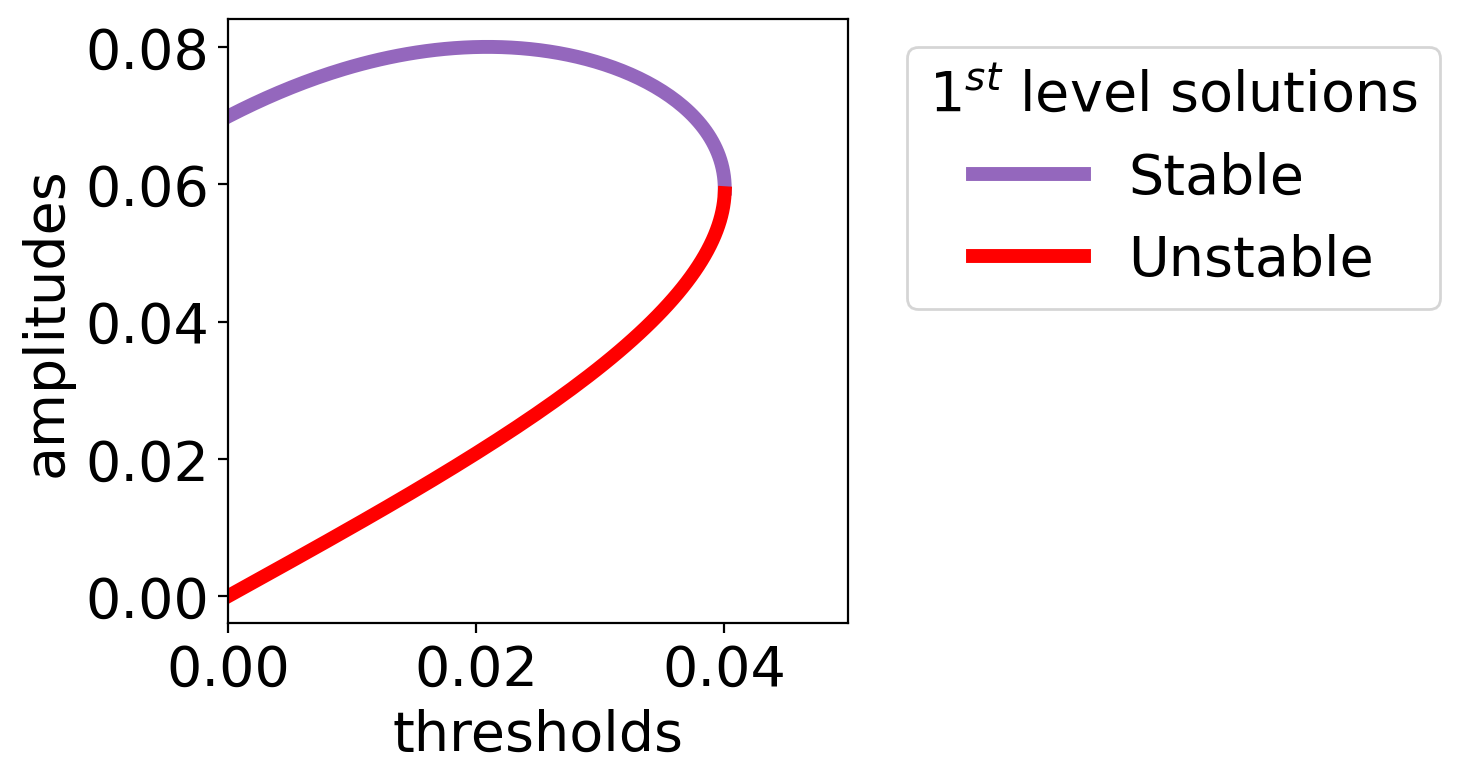

In [6]:
#Solving for possible thresholds and stability
Low_level_thetas=fun.first_stationary_sol(steps, halfwidths, w_coeffs)
stability=[]
for i in range(200):
    if not(np.isnan(Low_level_thetas[i])):
        stability+=[fun.stability(1, steps, w_coeffs, [halfwidths[i]])]
    else:
        stability+=[np.nan]

Amplitude_solution=np.array([fun.amplitude(steps, w_coeffs,[half]) for half in halfwidths])

#Masking stable and unstable solutions in each branch
Unstable = np.ma.masked_where(np.array(stability) == -1, Amplitude_solution) 
Stable = np.ma.masked_where(np.array(stability) == 1, Amplitude_solution)

fig = plt.figure(figsize=(4, 4))
plt.plot(Low_level_thetas, Stable, '-',label='Stable', color='tab:purple')
plt.plot(Low_level_thetas, Unstable, '-',color='red',label='Unstable')

plt.xlabel('thresholds')
plt.ylabel('amplitudes')
plt.legend(title='$1^{st}$ level solutions', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.xlim(0,0.05)

We choose the first threshold: 0.035. 

We have found that for this model set up, the shape of each bump profile is largely a scaled version of the lowest level bump; that is, normalized Fourier coefficients of each bump remain nearly identical to the lowest level bump. This is useful in finding subsequent stationary solutions since we can utilize the lower dimensional amplitude equation to solve for subsequent amplitude stationary states rather than solving an increasingly complex nonlinear system for mutliple bump interfaces. 

We first find the NORMALIZED activity bump profile coefficients. Note that these will depend on the choice of the first threshold, thus changes to the first threshold (and thus halfwidth) may slightly alter subsequent solution regions.

In [7]:
#Check for a proper lowest bump. 
#Note: The latter thresholds are chosen such that it cannot be reached.
place_holder=10
step_theta=[0.035, place_holder, place_holder, place_holder, place_holder]

Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

#Changing duration of cue
FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)


#normalized coefficients from simulation
Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Full model simulation')

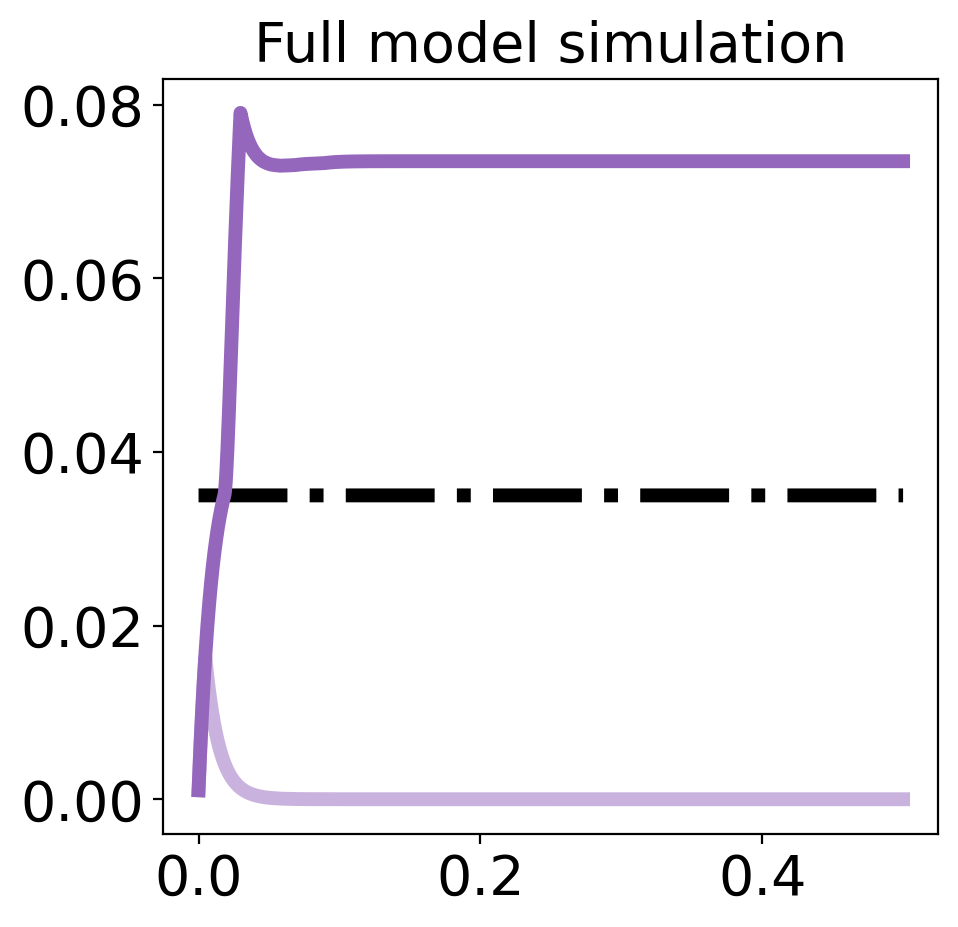

In [8]:
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)

nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

#Plotting the on/off states for the first threshold
fig = plt.figure(figsize=(5, 5))
plt.plot(timey,step_theta[0]*np.ones(nt),'-.', alpha=1, color='black')
plt.plot(timey,Amplitudes0, alpha=0.5, color='tab:purple', label='10 ms')
plt.plot(timey,Amplitudes1, alpha=1, color='tab:purple', label='25 ms')
plt.title('Full model simulation')

### Choosing subsequent thresholds

First we find the next set of amplitudes and thresholds given the chosen threshold_1=0.035.

In [9]:
#vector of possible amplitudes
Avec=np.linspace(0.001,0.4,500)

#Update the following when searching for the next solution:
finding_state=2 #1. the state B you are searching for solutions
known_theta=[0.035] #2. the chosen thetas for prior steps
thvector2=np.linspace(0.03,0.2,100) #3. the range of theta to search

#4. the state number for the solution vectors here...and inside the for loop
stationary2=[]
stable2=[]
stationary_narrow2=[]
stablen2=[]

for theta in tqdm(thvector2):
    sol_ampl_n, sol_ampl_b=fun.stationary_ampl(steps, weight_tot, Normal_Ucoeffs, known_theta, theta, Avec ,x)
    stationary_narrow2+=[sol_ampl_n]
    stationary2+=[sol_ampl_b]
    Ub=sol_ampl_b*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    Un=sol_ampl_n*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    if not(np.isnan(sol_ampl_n)) and not(np.isnan(sol_ampl_b)):
        half_b=np.array([fun.find_interfaces(x, Ub, th) for th in known_theta]
                        +[fun.find_interfaces(x, Ub, theta)])
                          
        half_n=np.array([fun.find_interfaces(x, Un, th) for th in known_theta]
                        +[fun.find_interfaces(x, Un, theta-10**(-3))]) 
        
        stable2+=[fun.stability(finding_state, steps, w_coeffs, half_b[half_b>0])]
        stablen2+=[fun.stability(finding_state, steps, w_coeffs, half_n[half_n>0])]
    else:
        stable2+=[np.nan]
        stablen2+=[np.nan]
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
#Masking stable and unstable solutions in each branch
solUnstable2 = np.ma.masked_where(np.array(stable2) == -1, stationary2) 
solStable2 = np.ma.masked_where(np.array(stable2) == 1, stationary2)

solUnstablen2 = np.ma.masked_where(np.array(stablen2) == -1, stationary_narrow2) 
solStablen2 = np.ma.masked_where(np.array(stablen2) == 1, stationary_narrow2)


Text(0, 0.5, 'Amplitudes')

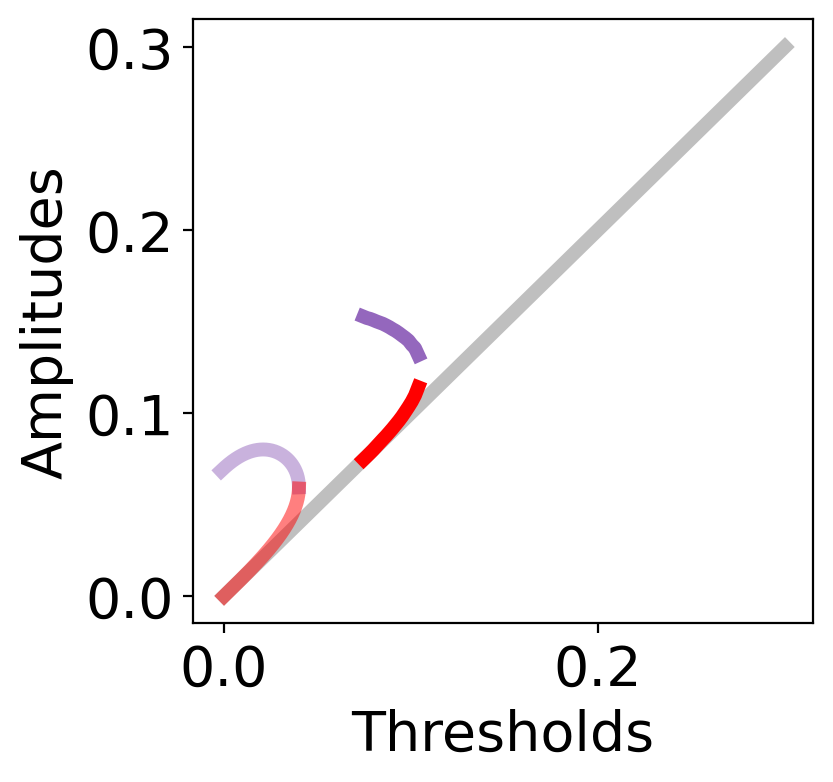

In [11]:
fig = plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='grey', alpha=0.5)

plt.plot(Low_level_thetas, Stable,label='Stable', color='tab:purple', alpha=0.5)
plt.plot(Low_level_thetas, Unstable,color='red',label='Unstable', alpha=0.5)

plt.plot(thvector2, solStable2,color='tab:purple', alpha=1)
plt.plot(thvector2, solUnstable2,color='red', alpha=1)
plt.plot(thvector2, solUnstablen2,color='red', alpha=1)


plt.xlabel('Thresholds')
plt.ylabel('Amplitudes')



In [12]:
#We set the second threshold to be 0.1, the others are placeholders
step_theta=[0.035, 0.1, place_holder, place_holder, place_holder]


In [13]:
Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

#normalized coefficients from simulation
Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
# Pulling all amplitudes
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)

(0.0, 0.2)

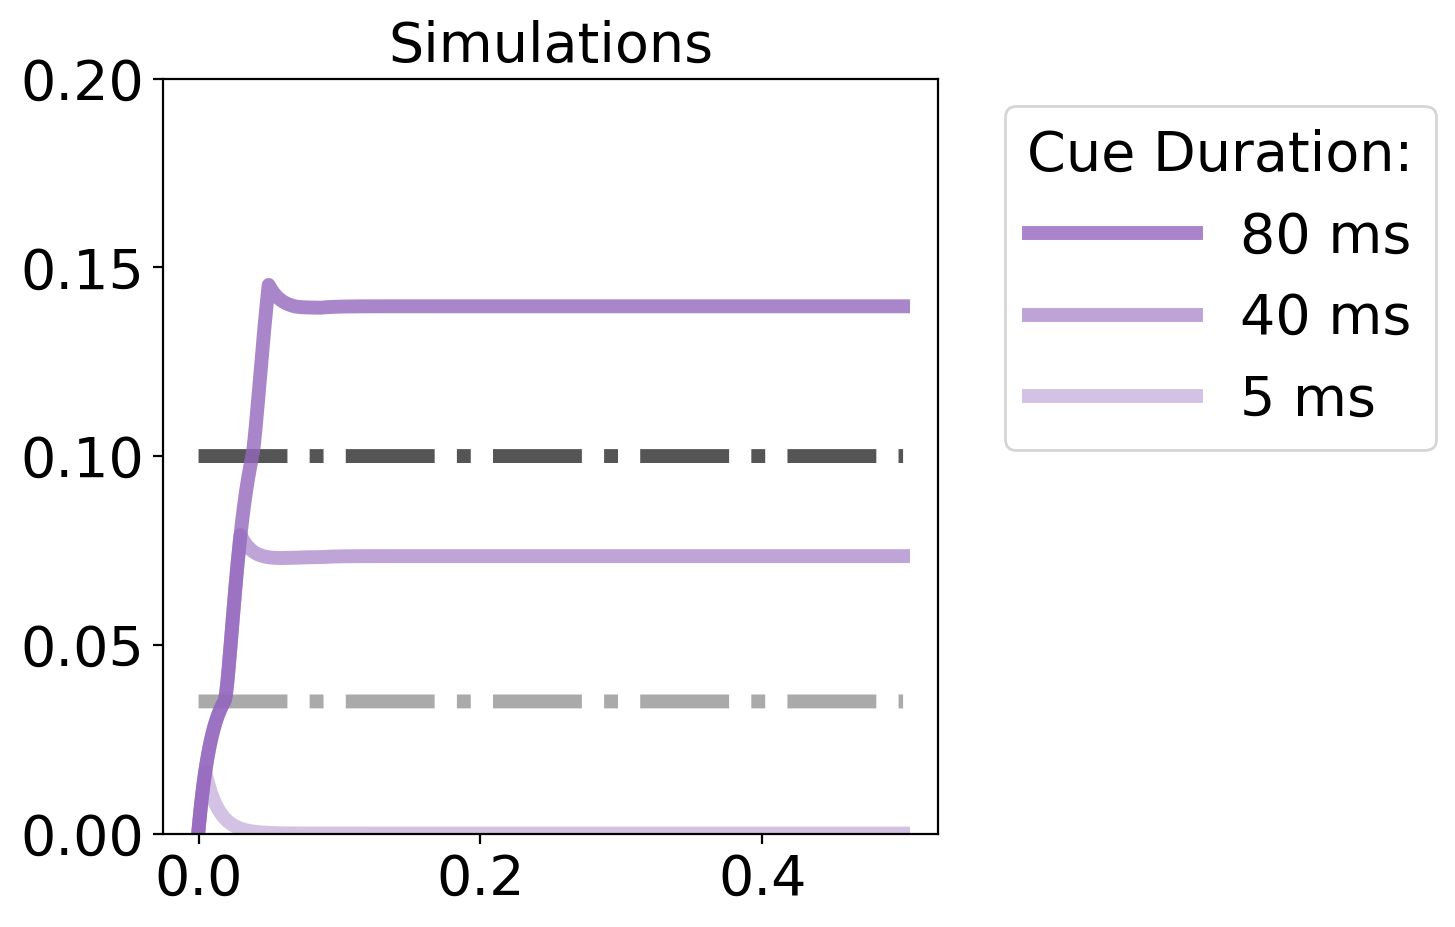

In [15]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)*1/3, color='black')

plt.plot(timey,Amplitudes0, alpha=0.4, color='tab:purple', label='5 ms')
plt.plot(timey,Amplitudes1, alpha=0.6, color='tab:purple', label='40 ms')
plt.plot(timey,Amplitudes2, alpha=0.8, color='tab:purple', label='80 ms')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)
plt.title('Simulations')
plt.ylim(0,0.2)

In [16]:
#vector of possible amplitudes
Avec=np.linspace(0.001,0.4,500)

#Update the following when searching for the next solution:
finding_state=3 #1. the state B you are searching for solutions
known_theta=[0.035,0.1] #2. the chosen thetas for prior steps
thvector3=np.linspace(0.1,0.2,100) #3. the range of theta to search

#4. the state number for the solution vectors here, inside the for loop, in the graphs below
stationary3=[]
stable3=[]
stationary_narrow3=[]
stablen3=[]

for theta in tqdm(thvector3):
    sol_ampl_n, sol_ampl_b=fun.stationary_ampl(steps, weight_tot, Normal_Ucoeffs, known_theta, theta, Avec ,x)
    stationary_narrow3+=[sol_ampl_n]
    stationary3+=[sol_ampl_b]
    Ub=sol_ampl_b*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    Un=sol_ampl_n*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    if not(np.isnan(sol_ampl_n)) and not(np.isnan(sol_ampl_b)):
        half_b=np.array([fun.find_interfaces(x, Ub, th) for th in known_theta]
                        +[fun.find_interfaces(x, Ub, theta)])
                          
        half_n=np.array([fun.find_interfaces(x, Un, th) for th in known_theta]
                        +[fun.find_interfaces(x, Un, theta-10**(-3))]) 
        
        stable3+=[fun.stability(finding_state, steps, w_coeffs, half_b[half_b>0])]
        stablen3+=[fun.stability(finding_state, steps, w_coeffs, half_n[half_n>0])]
    else:
        stable3+=[np.nan]
        stablen3+=[np.nan]
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
#Masking stable and unstable solutions in each branch
solUnstable3 = np.ma.masked_where(np.array(stable3) == -1, stationary3) 
solStable3 = np.ma.masked_where(np.array(stable3) == 1, stationary3)

solUnstablen3 = np.ma.masked_where(np.array(stablen3) == -1, stationary_narrow3) 
solStablen3 = np.ma.masked_where(np.array(stablen3) == 1, stationary_narrow3)


Text(0, 0.5, 'Amplitudes')

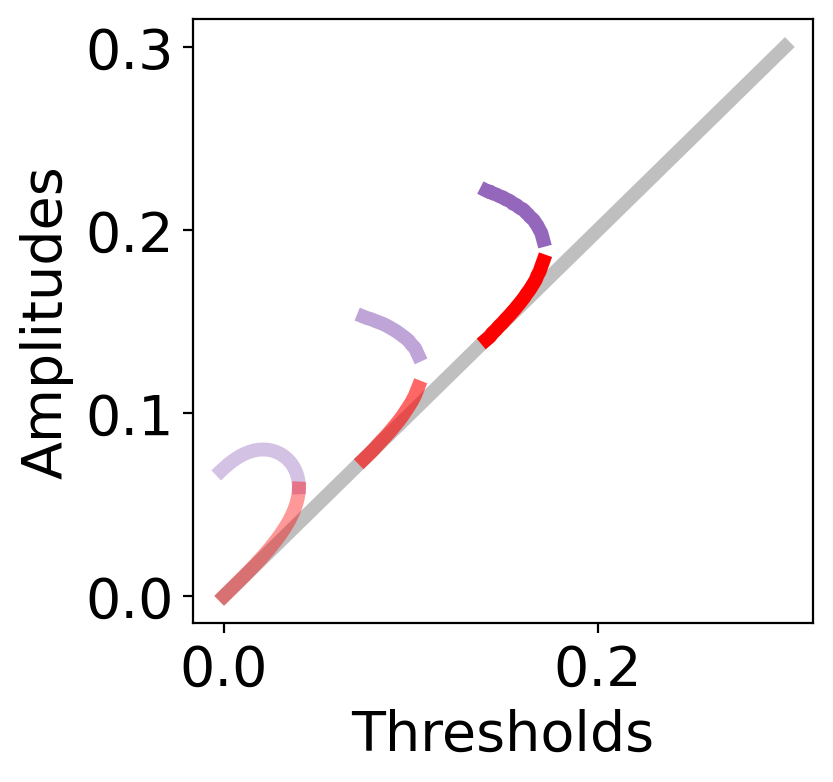

In [18]:
fig = plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='grey', alpha=0.5)

plt.plot(Low_level_thetas, Stable,label='Stable', color='tab:purple', alpha=0.4)
plt.plot(Low_level_thetas, Unstable,color='red',label='Unstable', alpha=0.4)

plt.plot(thvector2, solStable2,color='tab:purple', alpha=0.6)
plt.plot(thvector2, solUnstable2,color='red', alpha=0.6)
plt.plot(thvector2, solUnstablen2,color='red', alpha=0.6)


plt.plot(thvector3, solStable3, color='tab:purple', alpha=1)
plt.plot(thvector3, solUnstable3, color='red', alpha=1)
plt.plot(thvector3, solUnstablen3, color='red', alpha=1)

plt.xlabel('Thresholds')
plt.ylabel('Amplitudes')


In [19]:
#We set the second threshold to be 0.1, the others are placeholders
step_theta=[0.035, 0.1, 0.165, place_holder, place_holder]


In [20]:
Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=7
Result3=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)


#normalized coefficients from simulation
Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
# Pulling all amplitudes
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)
Amplitudes3=np.max(Result3,axis=0)

(0.0, 0.3)

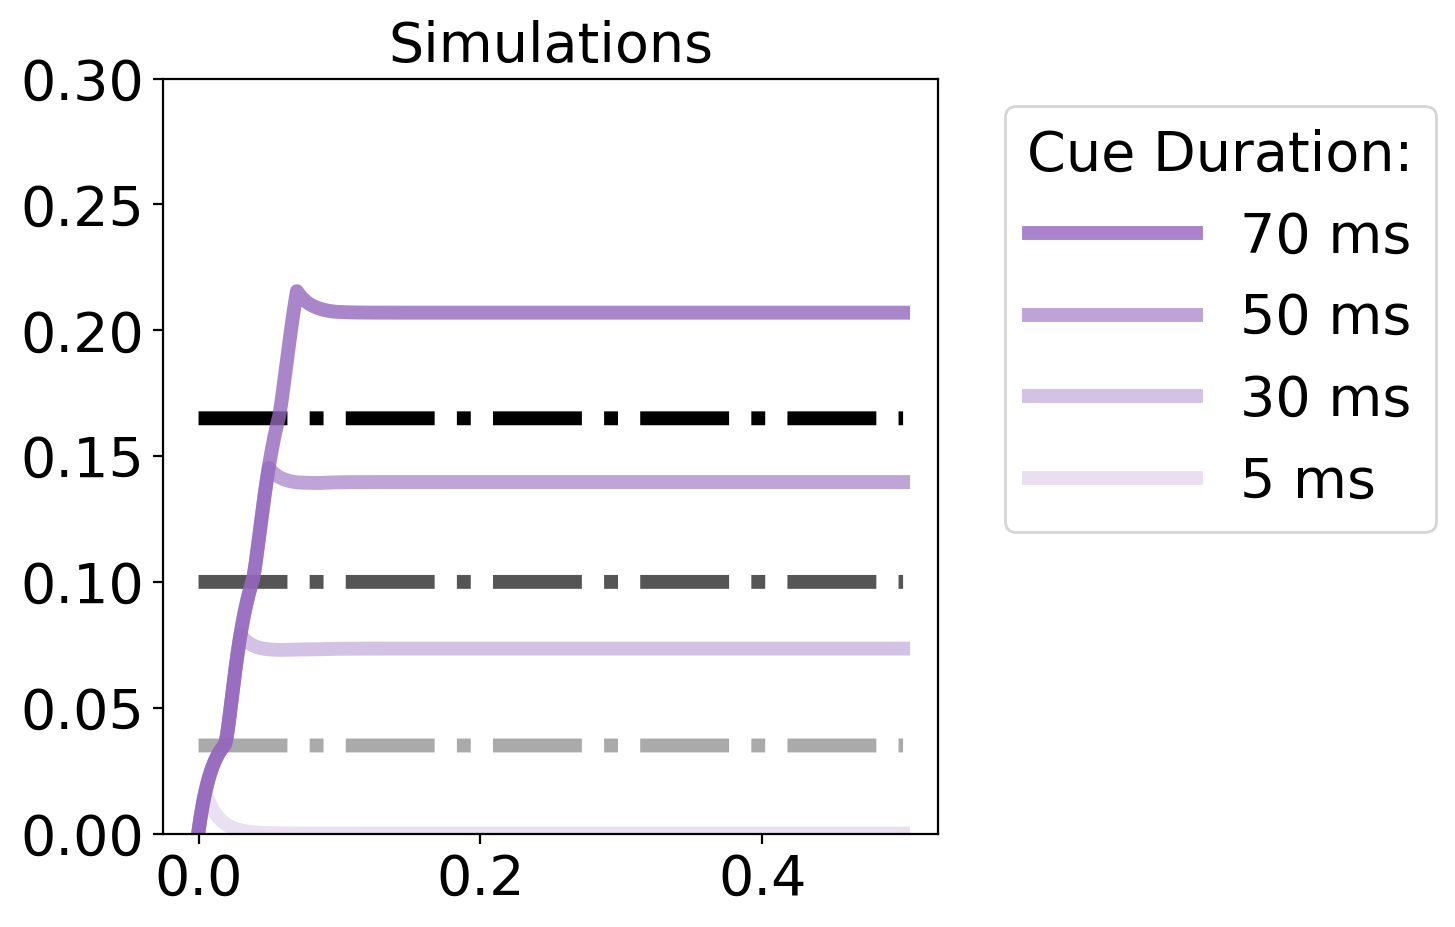

In [22]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)*1/3, color='black')

plt.plot(timey,Amplitudes0, alpha=0.2, color='tab:purple', label='5 ms')
plt.plot(timey,Amplitudes1, alpha=0.4, color='tab:purple', label='30 ms')
plt.plot(timey,Amplitudes2, alpha=0.6, color='tab:purple', label='50 ms')
plt.plot(timey,Amplitudes3, alpha=0.8, color='tab:purple', label='70 ms')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)
plt.title('Simulations')
plt.ylim(0,0.3)

In [23]:
#vector of possible amplitudes
Avec=np.linspace(0.001,0.4,500)

#Update the following when searching for the next solution:
finding_state=4 #1. the state B you are searching for solutions
known_theta=[0.035,0.1,0.165] #2. the chosen thetas for prior steps
thvector4=np.linspace(0.16,0.3,100) #3. the range of theta to search

#4. the state number for the solution vectors here...and inside the for loop
stationary4=[]
stable4=[]
stationary_narrow4=[]
stablen4=[]

for theta in tqdm(thvector4):
    sol_ampl_n, sol_ampl_b=fun.stationary_ampl(steps, weight_tot, Normal_Ucoeffs, known_theta, theta, Avec ,x)
    stationary_narrow4+=[sol_ampl_n]
    stationary4+=[sol_ampl_b]
    Ub=sol_ampl_b*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    Un=sol_ampl_n*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    if not(np.isnan(sol_ampl_n)) and not(np.isnan(sol_ampl_b)):
        half_b=np.array([fun.find_interfaces(x, Ub, th) for th in known_theta]
                        +[fun.find_interfaces(x, Ub, theta)])
                          
        half_n=np.array([fun.find_interfaces(x, Un, th) for th in known_theta]
                        +[fun.find_interfaces(x, Un, theta-10**(-3))]) 
        
        stable4+=[fun.stability(finding_state, steps, w_coeffs, half_b[half_b>0])]
        stablen4+=[fun.stability(finding_state, steps, w_coeffs, half_n[half_n>0])]
    else:
        stable4+=[np.nan]
        stablen4+=[np.nan]
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
#Masking stable and unstable solutions in each branch
solUnstable4 = np.ma.masked_where(np.array(stable4) == -1, stationary4) 
solStable4 = np.ma.masked_where(np.array(stable4) == 1, stationary4)

solUnstablen4 = np.ma.masked_where(np.array(stablen4) == -1, stationary_narrow4) 
solStablen4 = np.ma.masked_where(np.array(stablen4) == 1, stationary_narrow4)


Text(0, 0.5, 'Amplitudes')

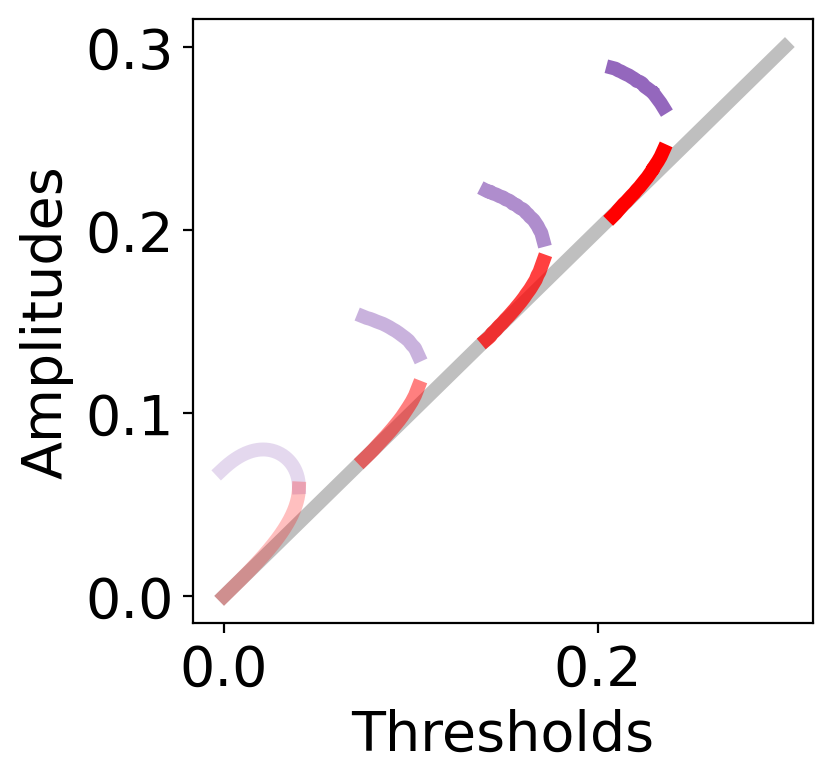

In [25]:
fig = plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='grey', alpha=0.5)

plt.plot(Low_level_thetas, Stable,label='Stable', color='tab:purple', alpha=0.25)
plt.plot(Low_level_thetas, Unstable,color='red',label='Unstable', alpha=0.25)

plt.plot(thvector2, solStable2,color='tab:purple', alpha=0.5)
plt.plot(thvector2, solUnstable2,color='red', alpha=0.5)
plt.plot(thvector2, solUnstablen2,color='red', alpha=0.5)


plt.plot(thvector3, solStable3, color='tab:purple', alpha=0.75)
plt.plot(thvector3, solUnstable3, color='red', alpha=0.75)
plt.plot(thvector3, solUnstablen3, color='red', alpha=0.75)

plt.plot(thvector4, solStable4, color='tab:purple', alpha=1)
plt.plot(thvector4, solUnstable4, color='red', alpha=1)
plt.plot(thvector4, solUnstablen4, color='red', alpha=1)


plt.xlabel('Thresholds')
plt.ylabel('Amplitudes')


In [26]:
#We set the second threshold to be 0.1, the others are placeholders
step_theta=[0.035, 0.1, 0.165, 0.234, place_holder]


In [27]:
Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=7
Result3=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=9
Result4=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
#normalized coefficients from simulation
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
# Pulling all amplitudes
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)
Amplitudes3=np.max(Result3,axis=0)
Amplitudes4=np.max(Result4,axis=0)

(0.0, 0.3)

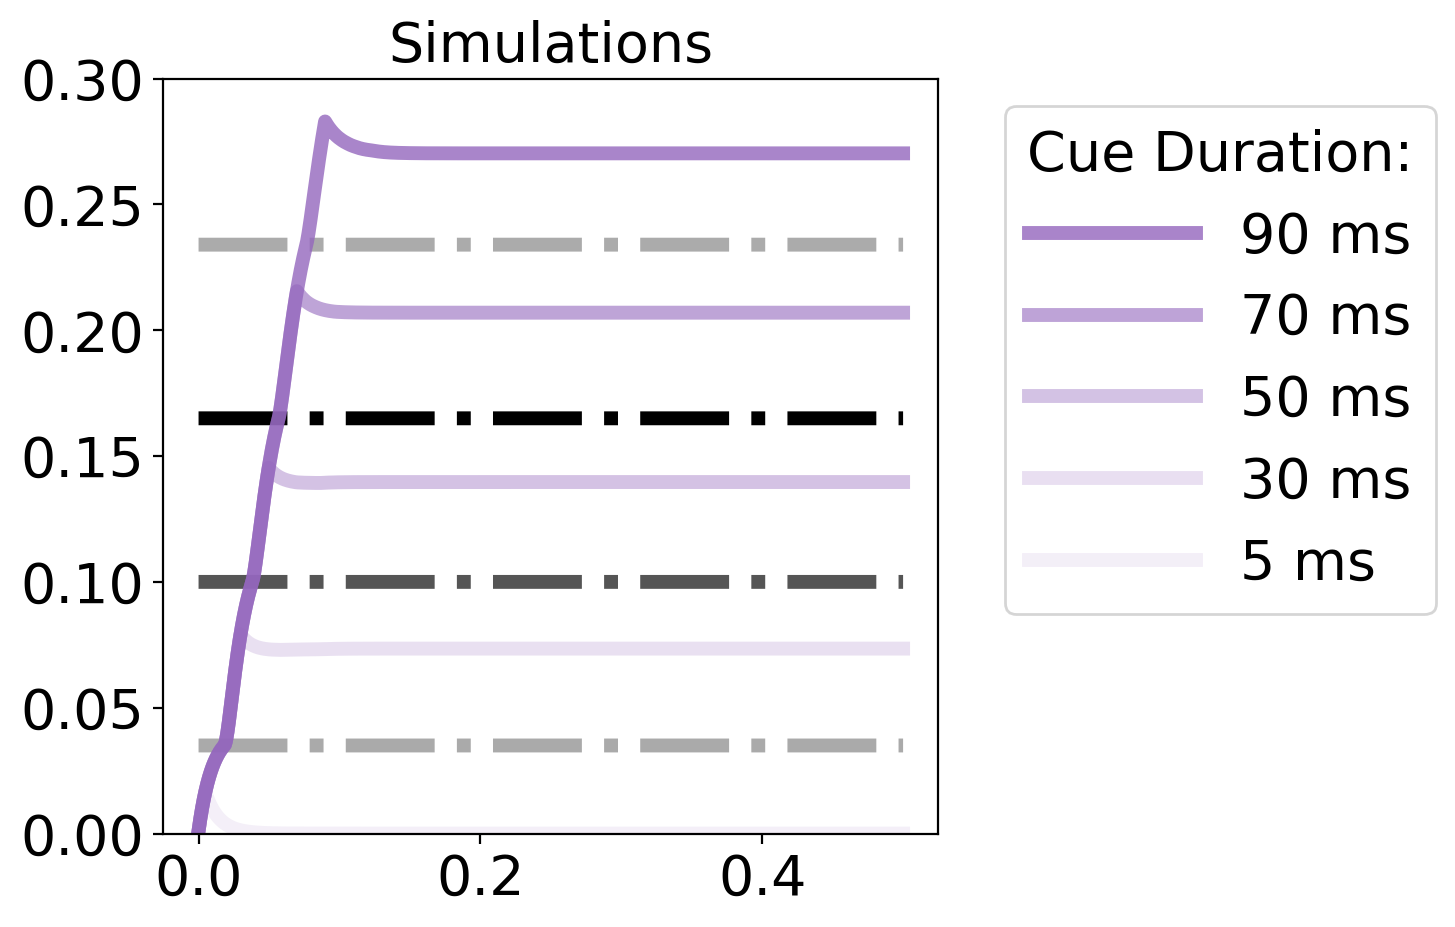

In [29]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)*1/3, color='black')

plt.plot(timey,Amplitudes0, alpha=0.1, color='tab:purple', label='5 ms')
plt.plot(timey,Amplitudes1, alpha=0.2, color='tab:purple', label='30 ms')
plt.plot(timey,Amplitudes2, alpha=0.4, color='tab:purple', label='50 ms')
plt.plot(timey,Amplitudes3, alpha=0.6, color='tab:purple', label='70 ms')
plt.plot(timey,Amplitudes4, alpha=0.8, color='tab:purple', label='90 ms')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)
plt.title('Simulations')
plt.ylim(0,0.3)

In [30]:
#vector of possible amplitudes
Avec=np.linspace(0.001,0.4,500)

#Update the following when searching for the next solution:
finding_state=5 #1. the state B you are searching for solutions
known_theta=[0.035,0.1,0.165,0.234] #2. the chosen thetas for prior steps
thvector5=np.linspace(0.23,0.3,100) #3. the range of theta to search

#4. the state number for the solution vectors here...and inside the for loop
stationary5=[]
stable5=[]
stationary_narrow5=[]
stablen5=[]

for theta in tqdm(thvector5):
    sol_ampl_n, sol_ampl_b=fun.stationary_ampl(steps, weight_tot, Normal_Ucoeffs, known_theta, theta, Avec ,x)
    stationary_narrow5+=[sol_ampl_n]
    stationary5+=[sol_ampl_b]
    Ub=sol_ampl_b*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    Un=sol_ampl_n*sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])
    if not(np.isnan(sol_ampl_n)) and not(np.isnan(sol_ampl_b)):
        half_b=np.array([fun.find_interfaces(x, Ub, th) for th in known_theta]
                        +[fun.find_interfaces(x, Ub, theta)])
                          
        half_n=np.array([fun.find_interfaces(x, Un, th) for th in known_theta]
                        +[fun.find_interfaces(x, Un, theta-10**(-3))]) 
        
        stable5+=[fun.stability(finding_state, steps, w_coeffs, half_b[half_b>0])]
        stablen5+=[fun.stability(finding_state, steps, w_coeffs, half_n[half_n>0])]
    else:
        stable5+=[np.nan]
        stablen5+=[np.nan]
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
#Masking stable and unstable solutions in each branch
solUnstable5 = np.ma.masked_where(np.array(stable5) == -1, stationary5) 
solStable5 = np.ma.masked_where(np.array(stable5) == 1, stationary5)

solUnstablen5 = np.ma.masked_where(np.array(stablen5) == -1, stationary_narrow5) 
solStablen5 = np.ma.masked_where(np.array(stablen5) == 1, stationary_narrow5)


Text(0, 0.5, 'Amplitudes')

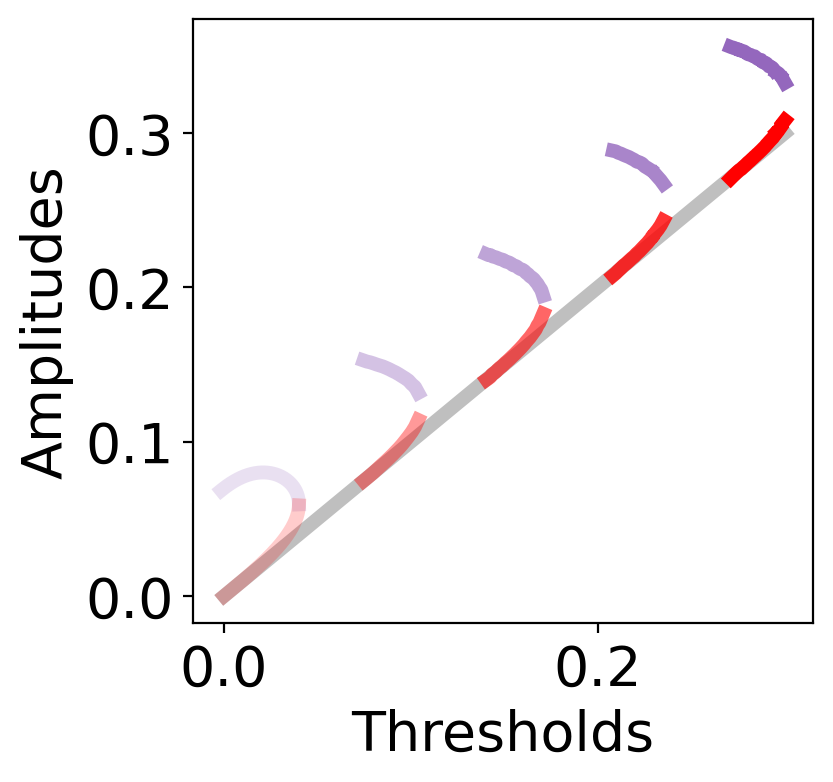

In [32]:
fig = plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='grey', alpha=0.5)

plt.plot(Low_level_thetas, Stable,label='Stable', color='tab:purple', alpha=0.2)
plt.plot(Low_level_thetas, Unstable,color='red',label='Unstable', alpha=0.2)

plt.plot(thvector2, solStable2,color='tab:purple', alpha=0.4)
plt.plot(thvector2, solUnstable2,color='red', alpha=0.4)
plt.plot(thvector2, solUnstablen2,color='red', alpha=0.4)


plt.plot(thvector3, solStable3, color='tab:purple', alpha=0.6)
plt.plot(thvector3, solUnstable3, color='red', alpha=0.6)
plt.plot(thvector3, solUnstablen3, color='red', alpha=0.6)

plt.plot(thvector4, solStable4, color='tab:purple', alpha=0.8)
plt.plot(thvector4, solUnstable4, color='red', alpha=0.8)
plt.plot(thvector4, solUnstablen4, color='red', alpha=0.8)

plt.plot(thvector5, solStable5, color='tab:purple', alpha=1)
plt.plot(thvector5, solUnstable5, color='red', alpha=1)
plt.plot(thvector5, solUnstablen5, color='red', alpha=1)

plt.xlabel('Thresholds')
plt.ylabel('Amplitudes')


In [33]:
#We set the second threshold to be 0.1, the others are placeholders
step_theta=[0.035, 0.1, 0.165, 0.234, 0.298]


In [34]:
Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=7
Result3=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=9
Result4=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=11
Result5=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

#normalized coefficients from simulation
Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [35]:
# Pulling all amplitudes
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)
Amplitudes3=np.max(Result3,axis=0)
Amplitudes4=np.max(Result4,axis=0)
Amplitudes5=np.max(Result5,axis=0)

Text(0.5, 1.0, 'Simulations')

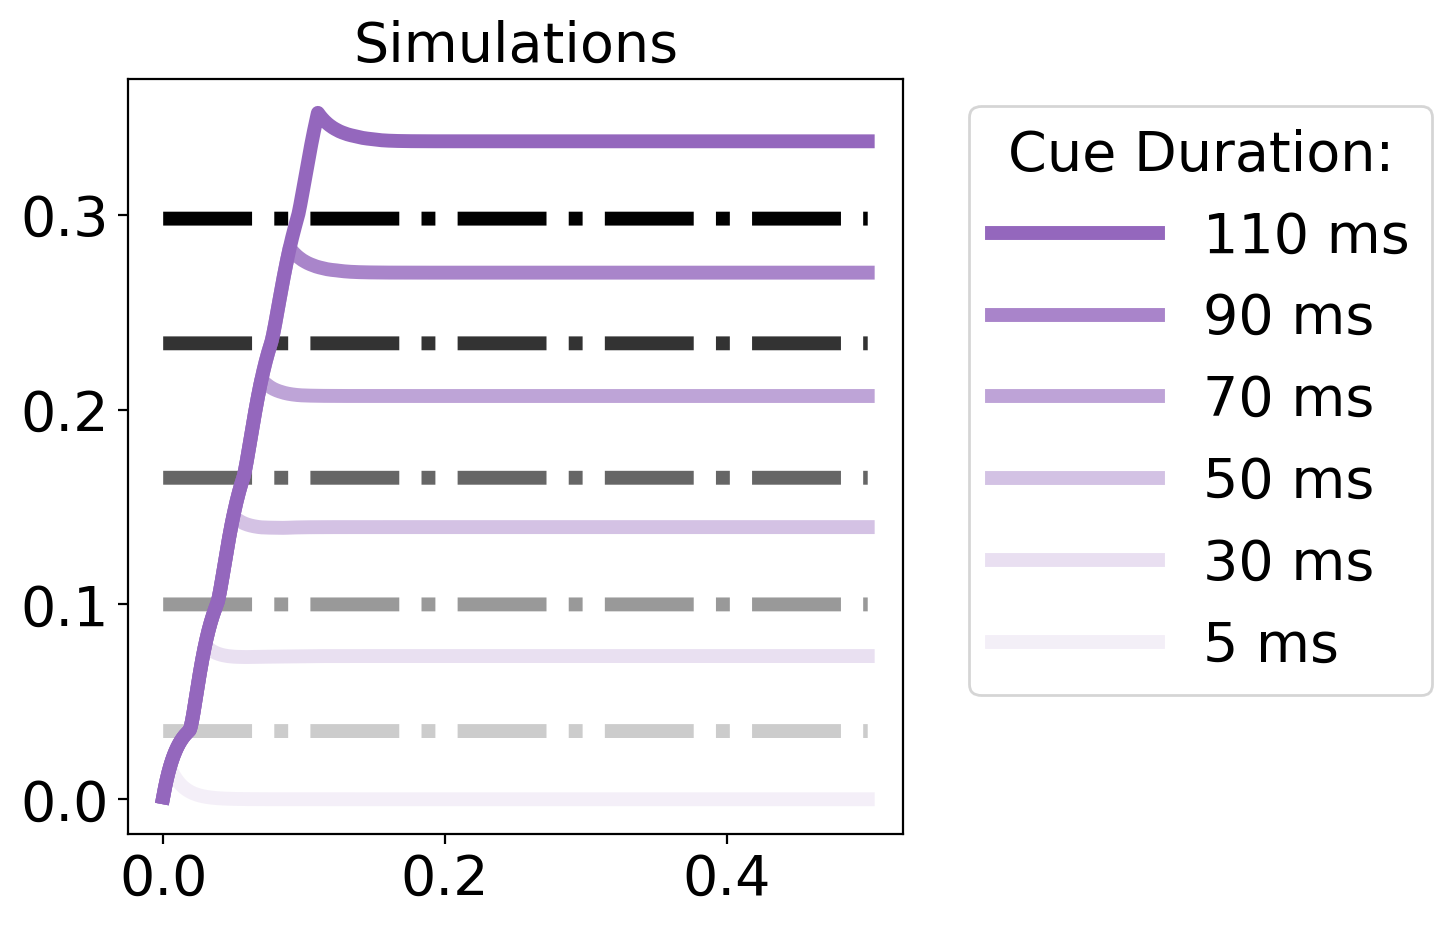

In [36]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)*1/5, color='black')

plt.plot(timey,Amplitudes0, alpha=0.1, color='tab:purple', label='5 ms')
plt.plot(timey,Amplitudes1, alpha=0.2, color='tab:purple', label='30 ms')
plt.plot(timey,Amplitudes2, alpha=0.4, color='tab:purple', label='50 ms')
plt.plot(timey,Amplitudes3, alpha=0.6, color='tab:purple', label='70 ms')
plt.plot(timey,Amplitudes4, alpha=0.8, color='tab:purple', label='90 ms')
plt.plot(timey,Amplitudes5, alpha=1, color='tab:purple', label='110 ms')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)
plt.title('Simulations')


### Comparing the full model and reduced amplitude equations

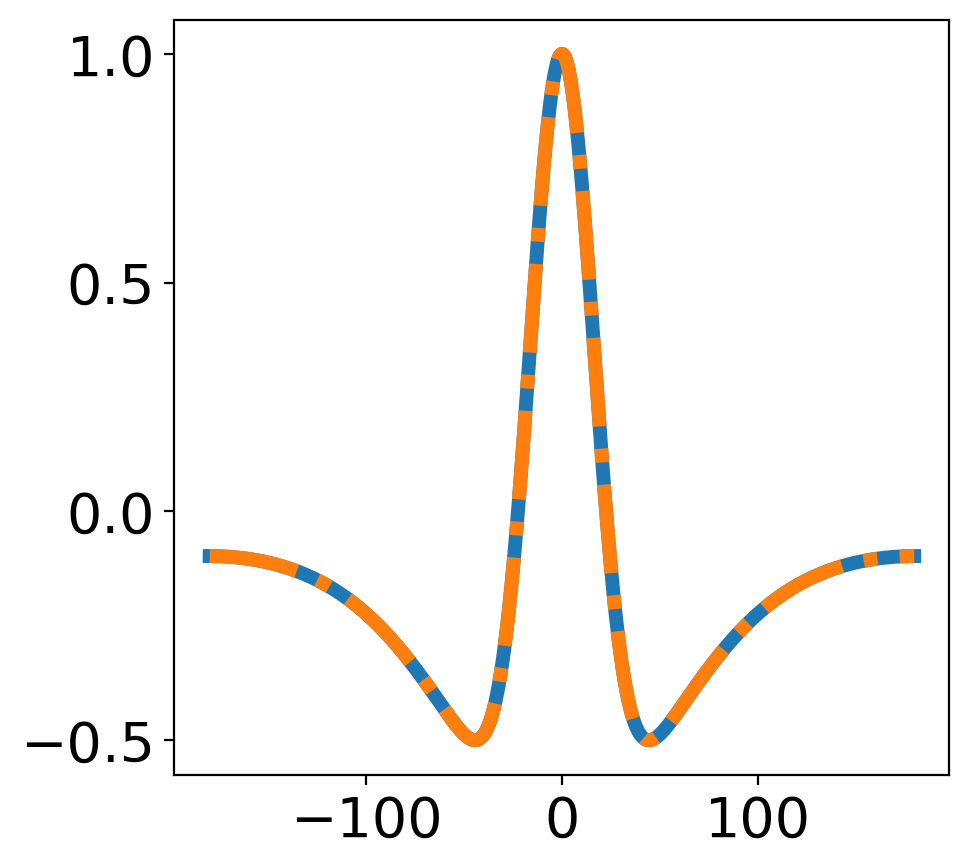

In [37]:
# Set U_tilde either with coefficients or from the final simulation profile
U_Tilde=np.array(sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))]))

fig = plt.figure(figsize=(5, 5))
plt.plot(x_deg, U_Tilde)
plt.plot(x_deg, Result5[:,-1]/Amplitudes5[-1],'-.')

In [38]:
step_theta=np.array([0.035,0.1,0.165,0.234,0.298])
Tend=50
Input=1*fun.Tophat(x, -0.02, 0.02)
InputA=1*fun.Tophat(x, -0.02, 0.02)
# U_Tilde=U_tilde(x)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 2,
    'Tend': Tend,
}



FixedParams['tce']=2
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)
Theory0_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory1_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory2_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=7
Result3=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory3_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=9
Result4=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory4_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=11
Result5=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory5_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

FixedParams['tce']=20
Result6=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)
Theory6_norm=fun.ampl_ansatz_norm(x, weight_tot, InputA, step_theta, 
                                 U_Tilde,**FixedParams)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [39]:
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)
Amplitudes3=np.max(Result3,axis=0)
Amplitudes4=np.max(Result4,axis=0)
Amplitudes5=np.max(Result5,axis=0)
Amplitudes6=np.max(Result6,axis=0)

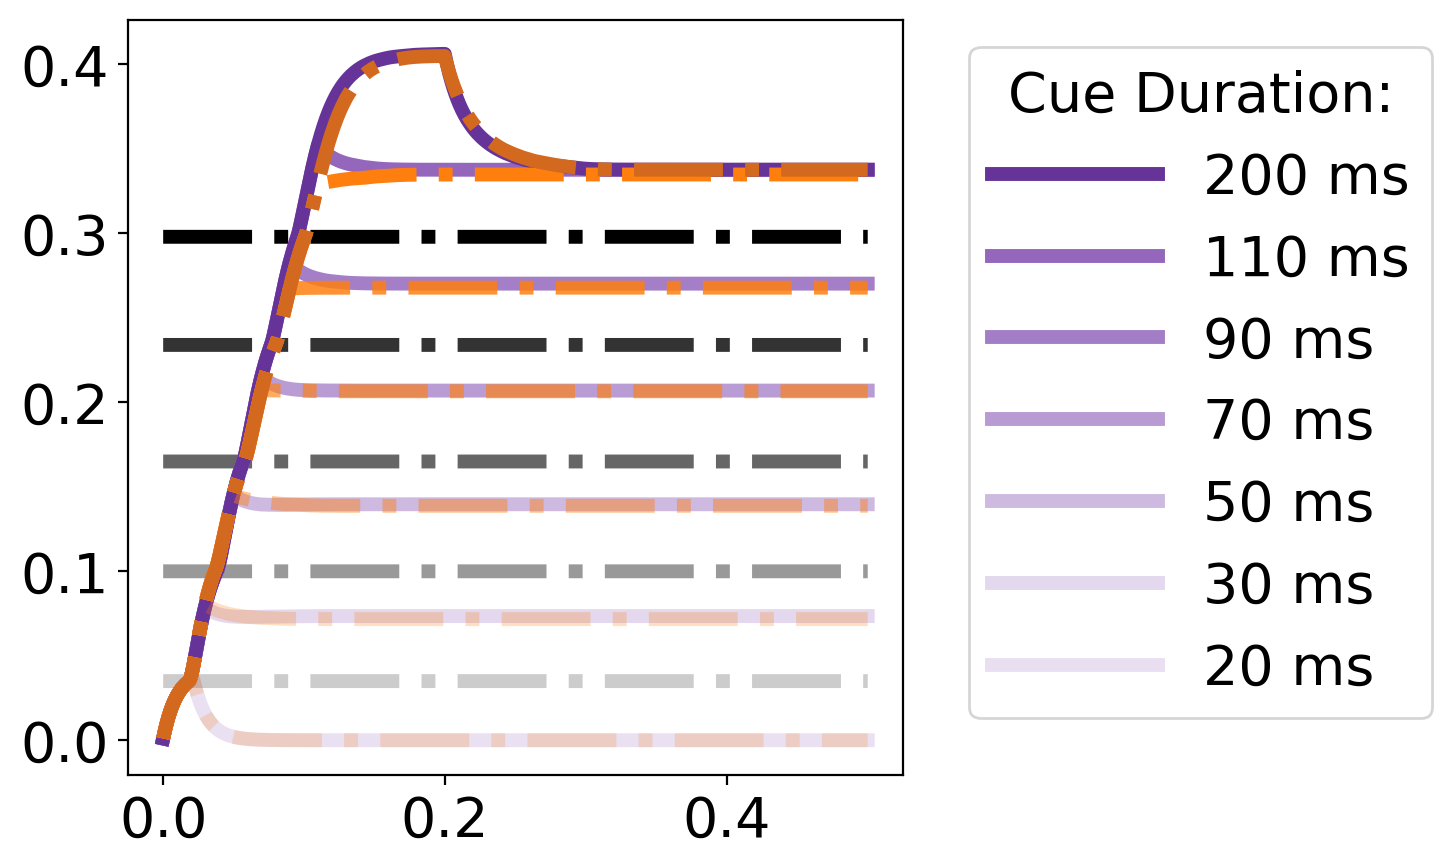

In [40]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)/5, color='black')
    
plt.plot(timey,Amplitudes0, alpha=0.2, color='tab:purple', label='20 ms')
plt.plot(timey,Amplitudes1, alpha=0.25, color='tab:purple', label='30 ms')
plt.plot(timey,Amplitudes2, alpha=0.45, color='tab:purple', label='50 ms')
plt.plot(timey,Amplitudes3, alpha=0.65, color='tab:purple', label='70 ms')
plt.plot(timey,Amplitudes4, alpha=0.85, color='tab:purple', label='90 ms')
plt.plot(timey,Amplitudes5, alpha=1, color='tab:purple', label='110 ms')
plt.plot(timey,Amplitudes6, alpha=1, color='rebeccapurple', label='200 ms')

plt.plot(timey,Theory0_norm,'-.', alpha=0.2, color='tab:orange')
plt.plot(timey,Theory1_norm,'-.', alpha=0.25, color='tab:orange')
plt.plot(timey,Theory2_norm,'-.', alpha=0.45, color='tab:orange')
plt.plot(timey,Theory3_norm,'-.', alpha=0.65, color='tab:orange')
plt.plot(timey,Theory4_norm,'-.', alpha=0.85, color='tab:orange')
plt.plot(timey,Theory5_norm,'-.', alpha=1, color='tab:orange')
plt.plot(timey,Theory6_norm,'-.', alpha=1, color='chocolate')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)

Figure notes: from the Result# arrays one can obtain the bump profiles. 
Final profiles can be obtained using Result#[:,-1].